# Image to Image Translational with C-GANS

![Gan Animation](./output/pix2pix/animation_small.gif)

In this notebook I implement the pix2pix network proposed by Isola et al. in [this paper](https://arxiv.org/abs/1611.07004). 

## Implementation Details

I follow the notation of Isola et al., so that I copy the quote of their explanation of the notation:
> Let Ck denote  a  Convolution-BatchNorm-ReLU  layer with k filters. CDk denotes a a Convolution-BatchNorm-Dropout-ReLU layer with a dropout rate of 50%. All convolutions are 4×4 spatial filters applied with stride 2. Convolutions in the encoder, and in the discriminator, downsample by a factor of 2, whereas in the decoder they upsample by a factor of 2.

Note: Downsampling / Upsampling by a factor of 2 with 4x4 filters and stride of 2 is achieved by use a padding of 1.

For further details, please see the paper for details.

### Generator Architecture

I implemented the econder - U-Net decoder style generator. Following the notation of Isola et al. (see above), they consist of:

encoder: C64-C128-C256-C512-C512-C512-C512-C512

U-Net decoder: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128

### Discriminator Architecture

I implemented the full 256x256 Discriminator (which takes the whole image as the input, not a patch). It consists of the following layers:

discriminator: C64-C128-C256-C512-C512-C512

In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torchvision import transforms, utils
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Data root dir
root_dir_data = './data/CMP_facade_DB_base'

# Image Size
img_size = 256

# In Filters
in_filter = 3

# Generator / Discriminator feature maps
ngf = 64
ndf = 64


# Training Details
num_epochs = 300
batch_size = 32


# Device to work on
device = torch.device("cuda:0" if (torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
num_gpu = torch.cuda.device_count()
print('Running on {} GPUs'.format(num_gpu) if num_gpu>0 else 'Running on CPU.')

Running on 1 GPUs


## Data set

In [3]:
class FacadeDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms=None):
        self.transforms = transforms
        self.image_path = os.path.join(root_dir, 'base_and_extended')
        file_list = os.listdir(self.image_path)
        self.img_list = []
        for f in file_list:
            file_ending= f[-3:]
            if file_ending == "png":
                self.img_list.append(f[:-3])
                
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_gt = Image.open(os.path.join(self.image_path, self.img_list[idx]+'jpg'))
        img_an = Image.open(os.path.join(self.image_path, self.img_list[idx]+'png'))
        img_an = img_an.convert("RGB")
        
        if self.transforms is not None:
            img_gt = self.transforms(img_gt)
            img_an = self.transforms(img_an)
        return (img_gt, img_an)

In [4]:
data_transforms = transforms.Compose([
        transforms.CenterCrop(img_size),
        transforms.Resize(img_size+30),
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [31]:
data_transforms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.Resize(img_size+30),
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [32]:
facade_dataset = FacadeDataset(root_dir_data, transforms=data_transforms)

In [33]:
dataloader = torch.utils.data.DataLoader(facade_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

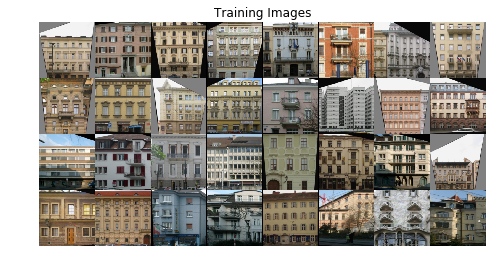

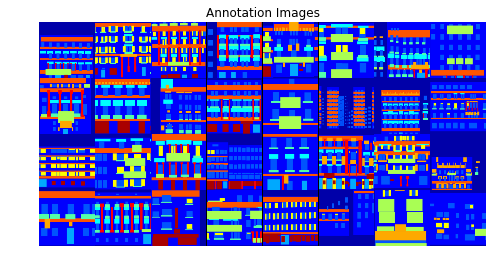

In [34]:
example_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(example_batch[0].to(device), nrow=8, padding=2, normalize=True),(1,2,0)))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Annotation Images")
plt.imshow(np.transpose(utils.make_grid(example_batch[1].to(device), nrow=8, padding=2, normalize=True),(1,2,0)))

## Models

I adopt the same model architectures as indicated in the paper

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #conv all 4x4 filters , stride 2, down/upsample by 2
        
        self.enc_1 = nn.Sequential(
            nn.Conv2d(in_filter, ngf, 4, 2, 1),
            #nn.BatchNorm2d(),
            nn.LeakyReLU(negative_slope=0.2)) 
        self.enc_2 = nn.Sequential(
            nn.Conv2d(ngf, ngf*2, 4, stride=2, padding=1),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(negative_slope=0.2))
        self.enc_3 = nn.Sequential(
            nn.Conv2d(ngf*2, ngf*4, 4, stride=2, padding=1),
            nn.BatchNorm2d(ngf*4),
            nn.LeakyReLU(negative_slope=0.2))
        self.enc_4 = nn.Sequential(
            nn.Conv2d(ngf*4, ngf*8, 4, stride=2, padding=1),
            nn.BatchNorm2d(ngf*8),
            nn.LeakyReLU(negative_slope=0.2))
        self.enc_5 = nn.Sequential(
            nn.Conv2d(ngf*8, ngf*8, 4, stride=2, padding=1),
            nn.BatchNorm2d(ngf*8),
            nn.LeakyReLU(negative_slope=0.2))
        self.enc_6 = nn.Sequential(
            nn.Conv2d(ngf*8, ngf*8, 4, stride=2, padding=1),
            nn.BatchNorm2d(ngf*8),
            nn.LeakyReLU(negative_slope=0.2))
        self.enc_7 = nn.Sequential(
            nn.Conv2d(ngf*8, ngf*8, 4, stride=2, padding=1),
            nn.BatchNorm2d(ngf*8),
            nn.LeakyReLU(negative_slope=0.2))
        self.enc_8 = nn.Sequential(
            nn.Conv2d(ngf*8, ngf*8, 4, stride=2, padding=1),
            nn.BatchNorm2d(ngf*8),
            nn.LeakyReLU(negative_slope=0.2))
        
        self.dec_1 = nn.Sequential(
            nn.ConvTranspose2d(ngf*8, ngf*8, 4, stride=2, padding=1),
            nn.BatchNorm2d(ngf*8),
            nn.Dropout(),
            nn.ReLU()) #2x2
        self.dec_2 = nn.Sequential(
            nn.ConvTranspose2d(16*ngf, 8*ngf, 4, stride=2, padding=1),
            nn.BatchNorm2d(8*ngf),
            nn.Dropout(),
            nn.ReLU()) #4x4
        self.dec_3 = nn.Sequential(
            nn.ConvTranspose2d(16*ngf, 8*ngf, 4, stride=2, padding=1),
            nn.BatchNorm2d(8*ngf),
            nn.Dropout(),
            nn.ReLU()) #8x8
        self.dec_4 = nn.Sequential(
            nn.ConvTranspose2d(16*ngf, 8*ngf, 4, stride=2, padding=1),
            nn.BatchNorm2d(8*ngf),
            nn.ReLU()) #16x16
        self.dec_5 = nn.Sequential(
            nn.ConvTranspose2d(16*ngf, 4*ngf, 4, stride=2, padding=1),
            nn.BatchNorm2d(4*ngf),
            nn.ReLU()) #32x32
        self.dec_6 = nn.Sequential(
            nn.ConvTranspose2d(8*ngf, 2*ngf, 4, stride=2, padding=1),
            nn.BatchNorm2d(2*ngf),
            nn.ReLU()) #64/64
        self.dec_7 = nn.Sequential(
            nn.ConvTranspose2d(4*ngf, ngf, 4, stride=2, padding=1),
            nn.BatchNorm2d(ngf),
            nn.ReLU()) #128x128
        self.dec_8 = nn.Sequential(
            nn.ConvTranspose2d(ngf*2, 3, 4, stride=2, padding=1),
            nn.Tanh()) # 256x256
        
    def forward(self, x):
        enc_1 = self.enc_1(x)
        enc_2 = self.enc_2(enc_1)
        enc_3 = self.enc_3(enc_2)
        enc_4 = self.enc_4(enc_3)
        enc_5 = self.enc_5(enc_4)
        enc_6 = self.enc_6(enc_5)
        enc_7 = self.enc_7(enc_6)
        enc_8 = self.enc_8(enc_7)
        
        dec_1 = self.dec_1(enc_8)
        dec_2 = self.dec_2(torch.cat([dec_1, enc_7], dim=1))
        dec_3 = self.dec_3(torch.cat([dec_2, enc_6], dim=1))
        dec_4 = self.dec_4(torch.cat([dec_3, enc_5], dim=1))
        dec_5 = self.dec_5(torch.cat([dec_4, enc_4], dim=1))
        dec_6 = self.dec_6(torch.cat([dec_5, enc_3], dim=1))
        dec_7 = self.dec_7(torch.cat([dec_6, enc_2], dim=1))
        dec_8 = self.dec_8(torch.cat([dec_7, enc_1], dim=1))
        
        return dec_8

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.dec_1 = nn.Sequential(
            nn.Conv2d(6, ndf, kernel_size=4, stride=2, padding=1),
            #nn.BatchNorm2d(ndf),
            nn.LeakyReLU(negative_slope=0.2)) # img_size / 2
        self.dec_2 = nn.Sequential(
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(negative_slope=0.2)) # img_size / 4
        self.dec_3 = nn.Sequential(
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(negative_slope=0.2)) # img_size / 8
        self.dec_4 = nn.Sequential(
            nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(negative_slope=0.2)) # img_size / 16
        self.dec_5 = nn.Sequential(
            nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(negative_slope=0.2)) # img_size / 32
        self.dec_6 = nn.Sequential(
            nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(negative_slope=0.2)) # img_size / 64
        self.dec_7 = nn.Sequential(
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=2, padding=0), # Use padding=0 to get 1-dim output
            nn.Sigmoid())
        
    def forward(self,cond, x):
        x = torch.cat([cond, x], dim=1)
        x = self.dec_1(x)
        x = self.dec_2(x)
        x = self.dec_3(x)
        x = self.dec_4(x)
        x = self.dec_5(x)
        x = self.dec_6(x)
        x = self.dec_7(x)
        return x

In [10]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)    

In [11]:
netG = Generator().to(device)
buffer = netG.apply(init_weights)

In [12]:
netD = Discriminator().to(device)
buffer = netD.apply(init_weights)

In [13]:
if (device.type == "cuda" and (num_gpu > 1)):
    netG = nn.DataParallel(netG)
    netD = nn.DataParallel(netD)

### Example Output (not trained)

Let's have a look at an exmple output, obviously not trained

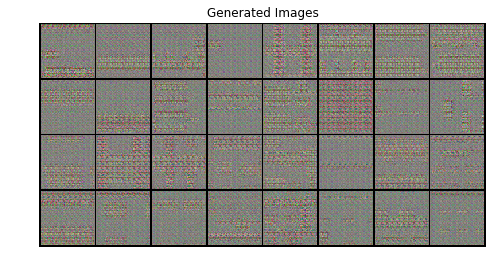

In [14]:
example_batch = next(iter(dataloader))
ann_imgs = example_batch[1].to(device)
outputs = netG(ann_imgs)


plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(utils.make_grid(outputs.detach().cpu(), nrow=8, padding=8, normalize=True),(1,2,0)))

## Training

In [15]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion_l1 = nn.L1Loss()
criterion_bce = nn.BCELoss()
num_batches_epoch = len(dataloader)

In [45]:
if os.path.isfile('./models/pix2pix_g.pt') and os.path.isfile('./models/pix2pix_d.pt'):
    netG.load_state_dict(torch.load('./models/pix2pix_g.pt'))
    netD.load_state_dict(torch.load('./models/pix2pix_d.pt'))
    print('Models loaded from file.')
else:
    for epoch in range(num_epochs):
        print("#"*20, "Epoch {}/{}".format(epoch+1, num_epochs), "#"*20)
        since = time.time()
        for i, data in enumerate(dataloader):
            since_b = time.time()
            data_img = data[0].to(device)
            data_ann = data[1].to(device)

            # Discriminator Loss
            netD.zero_grad()
            outputs_d_real = netD(data_ann, data_img)
            outputs_g = netG(data_ann)
            outputs_d_fake = netD(data_ann, outputs_g.detach())

            real_loss = criterion_bce(outputs_d_real, torch.full_like(outputs_d_real, 1, device=device))        
            fake_loss = criterion_bce(outputs_d_fake, torch.full_like(outputs_d_fake, 0, device=device))
            d_loss = (real_loss + fake_loss) / 2

            #Generator loss
            netG.zero_grad()
            l1_loss = criterion_l1(outputs_g, data_img)
            outputs_d_fake = netD(data_ann, outputs_g)
            gan_loss = criterion_bce(outputs_d_fake, torch.full_like(outputs_d_fake, 1, device=device))
            g_loss = gan_loss + l1_loss

            # Update Steps
            g_loss.backward()
            optimizerG.step() 
            d_loss.backward()
            optimizerD.step()

            if i%4 == 0:
                print("Batch {}/{}: \t D-Loss: {} \t G-Loss: {} \t D(x): {} \t D(G(z)): {} \t Time: {} s".format(i+1, num_batches_epoch, round(d_loss.item(),3), round(g_loss.item(),3), round(outputs_d_real.mean().item(), 3), round(outputs_d_fake.mean().item(),3),round(time.time()-since_b),3))

        print('Time for Epoch {}: {}\n'.format(epoch+1, time.time() - since))

    if(num_gpu > 1):
        torch.save(netG.module.state_dict(), './models/pix2pix_g.pt')
        torch.save(netD.module.state_dict(), './models/pix2pix_d.pt')
        print('Model saved.')
    else:
        torch.save(netG.state_dict(), './models/pix2pix_g.pt')
        torch.save(netD.state_dict(), './models/pix2pix_d.pt')
        print('Model saved.')

Models loaded from file.


In [50]:

dataloader_test = iter(torch.utils.data.DataLoader(facade_dataset, batch_size=8, shuffle=True, num_workers=4))
for i in range(10):
    data = next(dataloader_test)
    ann_imgs = data[1].to(device)
    outputs = netG(ann_imgs)

    ann_imgs = ann_imgs.cpu()
    outputs = outputs.detach().cpu()

    #outputs = [netG(ann_imgs) for i in range(8)]
    #outputs = torch.cat(outputs, dim=0)

    mixed_tensor = torch.cat([outputs[:4], ann_imgs[:4], outputs[4:8], ann_imgs[4:8]])
    utils.save_image(utils.make_grid(mixed_tensor, nrow=4, padding=2, normalize=True), './output/pix2pix/results_'+str(i+1)+'.png')